In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : [],
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_0_t1t2_normalized_e_e_e_1_1_e_1_0_diffusion_md_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(663976, 919)
(663976, 1)
validation
(128936, 919)
(128936, 1)
test
(61376, 919)
(61376, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 919)]             0         


 dense (Dense)               (None, 1024)              942080    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1631233 (6.22 MB)


Trainable params: 1631233 (6.22 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/67 [..............................] - ETA: 1:40 - loss: 0.0813 - STD: 2.7429e-04 - MAE: 0.2738

 3/67 [>.............................] - ETA: 1s - loss: 0.0397 - STD: 3.4321e-04 - MAE: 0.1543  

 6/67 [=>............................] - ETA: 1s - loss: 0.0371 - STD: 2.8238e-04 - MAE: 0.1494

 8/67 [==>...........................] - ETA: 1s - loss: 0.0351 - STD: 2.7864e-04 - MAE: 0.1439

11/67 [===>..........................] - ETA: 1s - loss: 0.0302 - STD: 3.1882e-04 - MAE: 0.1261

13/67 [====>.........................] - ETA: 4s - loss: 0.0285 - STD: 3.5380e-04 - MAE: 0.1215

16/67 [======>.......................] - ETA: 3s - loss: 0.0267 - STD: 3.9889e-04 - MAE: 0.1217

19/67 [=======>......................] - ETA: 3s - loss: 0.0248 - STD: 4.3412e-04 - MAE: 0.1175

22/67 [========>.....................] - ETA: 2s - loss: 0.0234 - STD: 4.5877e-04 - MAE: 0.1110

25/67 [==========>...................] - ETA: 2s - loss: 0.0224 - STD: 4.8037e-04 - MAE: 0.1060

28/67 [===========>..................] - ETA: 1s - loss: 0.0216 - STD: 5.0885e-04 - MAE: 0.1020

30/67 [============>.................] - ETA: 1s - loss: 0.0210 - STD: 5.3342e-04 - MAE: 0.1000

32/67 [=============>................] - ETA: 1s - loss: 0.0206 - STD: 5.6201e-04 - MAE: 0.0990

35/67 [==============>...............] - ETA: 1s - loss: 0.0200 - STD: 6.1074e-04 - MAE: 0.0982

38/67 [================>.............] - ETA: 1s - loss: 0.0195 - STD: 6.6359e-04 - MAE: 0.0969

41/67 [=================>............] - ETA: 1s - loss: 0.0191 - STD: 7.1872e-04 - MAE: 0.0951

44/67 [==================>...........] - ETA: 0s - loss: 0.0187 - STD: 7.8154e-04 - MAE: 0.0934

47/67 [====================>.........] - ETA: 0s - loss: 0.0184 - STD: 8.5867e-04 - MAE: 0.0920

50/67 [=====================>........] - ETA: 0s - loss: 0.0181 - STD: 9.5661e-04 - MAE: 0.0911

53/67 [======================>.......] - ETA: 0s - loss: 0.0178 - STD: 0.0011 - MAE: 0.0906    

56/67 [========================>.....] - ETA: 0s - loss: 0.0176 - STD: 0.0012 - MAE: 0.0898

59/67 [=========================>....] - ETA: 0s - loss: 0.0173 - STD: 0.0014 - MAE: 0.0889

62/67 [==========================>...] - ETA: 0s - loss: 0.0171 - STD: 0.0016 - MAE: 0.0879

65/67 [============================>.] - ETA: 0s - loss: 0.0169 - STD: 0.0018 - MAE: 0.0872

67/67 [==============================] - 5s 48ms/step - loss: 0.0168 - STD: 0.0021 - MAE: 0.0868 - val_loss: 0.0129 - val_STD: 0.0078 - val_MAE: 0.0713


Epoch 2/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0120 - STD: 0.0103 - MAE: 0.0727

 3/67 [>.............................] - ETA: 1s - loss: 0.0120 - STD: 0.0113 - MAE: 0.0726

 6/67 [=>............................] - ETA: 1s - loss: 0.0118 - STD: 0.0129 - MAE: 0.0710

 9/67 [===>..........................] - ETA: 1s - loss: 0.0115 - STD: 0.0149 - MAE: 0.0691

12/67 [====>.........................] - ETA: 1s - loss: 0.0111 - STD: 0.0175 - MAE: 0.0677

14/67 [=====>........................] - ETA: 1s - loss: 0.0109 - STD: 0.0197 - MAE: 0.0671

17/67 [======>.......................] - ETA: 1s - loss: 0.0105 - STD: 0.0233 - MAE: 0.0657

19/67 [=======>......................] - ETA: 1s - loss: 0.0102 - STD: 0.0260 - MAE: 0.0646

22/67 [========>.....................] - ETA: 1s - loss: 0.0097 - STD: 0.0304 - MAE: 0.0629

24/67 [=========>....................] - ETA: 1s - loss: 0.0094 - STD: 0.0336 - MAE: 0.0620

27/67 [===========>..................] - ETA: 0s - loss: 0.0089 - STD: 0.0384 - MAE: 0.0605

30/67 [============>.................] - ETA: 0s - loss: 0.0085 - STD: 0.0427 - MAE: 0.0592

33/67 [=============>................] - ETA: 0s - loss: 0.0082 - STD: 0.0468 - MAE: 0.0580

35/67 [==============>...............] - ETA: 0s - loss: 0.0080 - STD: 0.0493 - MAE: 0.0573

38/67 [================>.............] - ETA: 0s - loss: 0.0077 - STD: 0.0526 - MAE: 0.0562

41/67 [=================>............] - ETA: 0s - loss: 0.0074 - STD: 0.0557 - MAE: 0.0553

44/67 [==================>...........] - ETA: 0s - loss: 0.0072 - STD: 0.0585 - MAE: 0.0545

46/67 [===================>..........] - ETA: 0s - loss: 0.0071 - STD: 0.0602 - MAE: 0.0540

49/67 [====================>.........] - ETA: 0s - loss: 0.0069 - STD: 0.0623 - MAE: 0.0534

51/67 [=====================>........] - ETA: 0s - loss: 0.0068 - STD: 0.0637 - MAE: 0.0530

54/67 [=======================>......] - ETA: 0s - loss: 0.0066 - STD: 0.0653 - MAE: 0.0524

57/67 [========================>.....] - ETA: 0s - loss: 0.0065 - STD: 0.0670 - MAE: 0.0519

60/67 [=========================>....] - ETA: 0s - loss: 0.0064 - STD: 0.0686 - MAE: 0.0514

62/67 [==========================>...] - ETA: 0s - loss: 0.0063 - STD: 0.0694 - MAE: 0.0511

65/67 [============================>.] - ETA: 0s - loss: 0.0062 - STD: 0.0707 - MAE: 0.0507

67/67 [==============================] - 2s 29ms/step - loss: 0.0061 - STD: 0.0715 - MAE: 0.0505 - val_loss: 0.0046 - val_STD: 0.0800 - val_MAE: 0.0443


Epoch 3/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0038 - STD: 0.0954 - MAE: 0.0417

 4/67 [>.............................] - ETA: 1s - loss: 0.0038 - STD: 0.0986 - MAE: 0.0419

 7/67 [==>...........................] - ETA: 1s - loss: 0.0039 - STD: 0.0989 - MAE: 0.0422

 9/67 [===>..........................] - ETA: 1s - loss: 0.0038 - STD: 0.0994 - MAE: 0.0421

12/67 [====>.........................] - ETA: 1s - loss: 0.0038 - STD: 0.0986 - MAE: 0.0419

14/67 [=====>........................] - ETA: 1s - loss: 0.0038 - STD: 0.0983 - MAE: 0.0419

17/67 [======>.......................] - ETA: 1s - loss: 0.0038 - STD: 0.0987 - MAE: 0.0418

20/67 [=======>......................] - ETA: 1s - loss: 0.0038 - STD: 0.0982 - MAE: 0.0418

23/67 [=========>....................] - ETA: 1s - loss: 0.0038 - STD: 0.0986 - MAE: 0.0417

25/67 [==========>...................] - ETA: 1s - loss: 0.0038 - STD: 0.0983 - MAE: 0.0417

27/67 [===========>..................] - ETA: 0s - loss: 0.0038 - STD: 0.0984 - MAE: 0.0416

30/67 [============>.................] - ETA: 0s - loss: 0.0038 - STD: 0.0986 - MAE: 0.0416

33/67 [=============>................] - ETA: 0s - loss: 0.0038 - STD: 0.0986 - MAE: 0.0416

36/67 [===============>..............] - ETA: 0s - loss: 0.0037 - STD: 0.0986 - MAE: 0.0415

38/67 [================>.............] - ETA: 0s - loss: 0.0037 - STD: 0.0986 - MAE: 0.0415

40/67 [================>.............] - ETA: 0s - loss: 0.0037 - STD: 0.0988 - MAE: 0.0415

42/67 [=================>............] - ETA: 0s - loss: 0.0037 - STD: 0.0988 - MAE: 0.0414

45/67 [===================>..........] - ETA: 0s - loss: 0.0037 - STD: 0.0989 - MAE: 0.0413

48/67 [====================>.........] - ETA: 0s - loss: 0.0037 - STD: 0.0989 - MAE: 0.0413

51/67 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0991 - MAE: 0.0412

54/67 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0990 - MAE: 0.0412

56/67 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0991 - MAE: 0.0411

59/67 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0990 - MAE: 0.0410

61/67 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0991 - MAE: 0.0410

64/67 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0992 - MAE: 0.0410

67/67 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0993 - MAE: 0.0409

67/67 [==============================] - 2s 29ms/step - loss: 0.0036 - STD: 0.0993 - MAE: 0.0409 - val_loss: 0.0046 - val_STD: 0.0859 - val_MAE: 0.0451


Epoch 4/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0032 - STD: 0.1008 - MAE: 0.0390

 3/67 [>.............................] - ETA: 1s - loss: 0.0033 - STD: 0.0989 - MAE: 0.0394

 6/67 [=>............................] - ETA: 1s - loss: 0.0034 - STD: 0.1009 - MAE: 0.0395

 9/67 [===>..........................] - ETA: 1s - loss: 0.0033 - STD: 0.1007 - MAE: 0.0393

12/67 [====>.........................] - ETA: 1s - loss: 0.0033 - STD: 0.1006 - MAE: 0.0391

14/67 [=====>........................] - ETA: 1s - loss: 0.0033 - STD: 0.1003 - MAE: 0.0391

17/67 [======>.......................] - ETA: 1s - loss: 0.0033 - STD: 0.1006 - MAE: 0.0390

19/67 [=======>......................] - ETA: 1s - loss: 0.0033 - STD: 0.1008 - MAE: 0.0390

22/67 [========>.....................] - ETA: 1s - loss: 0.0033 - STD: 0.1008 - MAE: 0.0388

25/67 [==========>...................] - ETA: 1s - loss: 0.0033 - STD: 0.1009 - MAE: 0.0388

28/67 [===========>..................] - ETA: 0s - loss: 0.0032 - STD: 0.1011 - MAE: 0.0387

31/67 [============>.................] - ETA: 0s - loss: 0.0032 - STD: 0.1011 - MAE: 0.0386

34/67 [==============>...............] - ETA: 0s - loss: 0.0032 - STD: 0.1012 - MAE: 0.0385

37/67 [===============>..............] - ETA: 0s - loss: 0.0032 - STD: 0.1011 - MAE: 0.0384

40/67 [================>.............] - ETA: 0s - loss: 0.0032 - STD: 0.1012 - MAE: 0.0384

43/67 [==================>...........] - ETA: 0s - loss: 0.0032 - STD: 0.1013 - MAE: 0.0384

46/67 [===================>..........] - ETA: 0s - loss: 0.0032 - STD: 0.1013 - MAE: 0.0383

48/67 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.1014 - MAE: 0.0383

50/67 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.1015 - MAE: 0.0383

53/67 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.1014 - MAE: 0.0383

56/67 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.1015 - MAE: 0.0382

59/67 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.1015 - MAE: 0.0382

62/67 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.1015 - MAE: 0.0382

65/67 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.1016 - MAE: 0.0381

67/67 [==============================] - 2s 28ms/step - loss: 0.0032 - STD: 0.1015 - MAE: 0.0381 - val_loss: 0.0054 - val_STD: 0.0931 - val_MAE: 0.0479


Epoch 5/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0029 - STD: 0.1051 - MAE: 0.0366

 3/67 [>.............................] - ETA: 1s - loss: 0.0030 - STD: 0.1018 - MAE: 0.0370

 6/67 [=>............................] - ETA: 1s - loss: 0.0030 - STD: 0.1017 - MAE: 0.0367

 9/67 [===>..........................] - ETA: 1s - loss: 0.0029 - STD: 0.1024 - MAE: 0.0366

11/67 [===>..........................] - ETA: 1s - loss: 0.0029 - STD: 0.1032 - MAE: 0.0366

14/67 [=====>........................] - ETA: 1s - loss: 0.0029 - STD: 0.1031 - MAE: 0.0366

17/67 [======>.......................] - ETA: 1s - loss: 0.0029 - STD: 0.1029 - MAE: 0.0365

20/67 [=======>......................] - ETA: 1s - loss: 0.0029 - STD: 0.1031 - MAE: 0.0364

23/67 [=========>....................] - ETA: 1s - loss: 0.0029 - STD: 0.1033 - MAE: 0.0364

26/67 [==========>...................] - ETA: 0s - loss: 0.0029 - STD: 0.1031 - MAE: 0.0362

28/67 [===========>..................] - ETA: 0s - loss: 0.0029 - STD: 0.1032 - MAE: 0.0362

31/67 [============>.................] - ETA: 0s - loss: 0.0029 - STD: 0.1034 - MAE: 0.0362

34/67 [==============>...............] - ETA: 0s - loss: 0.0029 - STD: 0.1034 - MAE: 0.0361

37/67 [===============>..............] - ETA: 0s - loss: 0.0028 - STD: 0.1034 - MAE: 0.0361

39/67 [================>.............] - ETA: 0s - loss: 0.0028 - STD: 0.1033 - MAE: 0.0360

42/67 [=================>............] - ETA: 0s - loss: 0.0028 - STD: 0.1032 - MAE: 0.0360

44/67 [==================>...........] - ETA: 0s - loss: 0.0028 - STD: 0.1033 - MAE: 0.0360

47/67 [====================>.........] - ETA: 0s - loss: 0.0028 - STD: 0.1033 - MAE: 0.0360

50/67 [=====================>........] - ETA: 0s - loss: 0.0028 - STD: 0.1034 - MAE: 0.0360

53/67 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.1034 - MAE: 0.0360

55/67 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.1034 - MAE: 0.0360

58/67 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.1033 - MAE: 0.0361

60/67 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.1034 - MAE: 0.0360

63/67 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.1033 - MAE: 0.0361

66/67 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.1033 - MAE: 0.0362

67/67 [==============================] - 2s 28ms/step - loss: 0.0028 - STD: 0.1032 - MAE: 0.0361 - val_loss: 0.0065 - val_STD: 0.0945 - val_MAE: 0.0525


Epoch 6/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0030 - STD: 0.1069 - MAE: 0.0373

 4/67 [>.............................] - ETA: 1s - loss: 0.0028 - STD: 0.1040 - MAE: 0.0365

 6/67 [=>............................] - ETA: 1s - loss: 0.0028 - STD: 0.1032 - MAE: 0.0363

 9/67 [===>..........................] - ETA: 1s - loss: 0.0028 - STD: 0.1034 - MAE: 0.0362

12/67 [====>.........................] - ETA: 1s - loss: 0.0028 - STD: 0.1033 - MAE: 0.0361

15/67 [=====>........................] - ETA: 1s - loss: 0.0028 - STD: 0.1036 - MAE: 0.0361

18/67 [=======>......................] - ETA: 1s - loss: 0.0028 - STD: 0.1034 - MAE: 0.0360

20/67 [=======>......................] - ETA: 1s - loss: 0.0028 - STD: 0.1035 - MAE: 0.0359

23/67 [=========>....................] - ETA: 1s - loss: 0.0028 - STD: 0.1035 - MAE: 0.0358

26/67 [==========>...................] - ETA: 1s - loss: 0.0028 - STD: 0.1035 - MAE: 0.0359

29/67 [===========>..................] - ETA: 0s - loss: 0.0028 - STD: 0.1036 - MAE: 0.0358

31/67 [============>.................] - ETA: 0s - loss: 0.0027 - STD: 0.1036 - MAE: 0.0357

34/67 [==============>...............] - ETA: 0s - loss: 0.0027 - STD: 0.1036 - MAE: 0.0356

37/67 [===============>..............] - ETA: 0s - loss: 0.0027 - STD: 0.1037 - MAE: 0.0356

40/67 [================>.............] - ETA: 0s - loss: 0.0027 - STD: 0.1036 - MAE: 0.0355

43/67 [==================>...........] - ETA: 0s - loss: 0.0027 - STD: 0.1038 - MAE: 0.0355

46/67 [===================>..........] - ETA: 0s - loss: 0.0027 - STD: 0.1039 - MAE: 0.0354

48/67 [====================>.........] - ETA: 0s - loss: 0.0027 - STD: 0.1039 - MAE: 0.0354

51/67 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.1039 - MAE: 0.0354

54/67 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.1041 - MAE: 0.0353

57/67 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.1041 - MAE: 0.0353

59/67 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.1041 - MAE: 0.0353

62/67 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.1042 - MAE: 0.0353

65/67 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.1042 - MAE: 0.0352

67/67 [==============================] - 2s 28ms/step - loss: 0.0027 - STD: 0.1042 - MAE: 0.0352 - val_loss: 0.0062 - val_STD: 0.0934 - val_MAE: 0.0526


Epoch 7/10000


 1/67 [..............................] - ETA: 4s - loss: 0.0025 - STD: 0.1017 - MAE: 0.0339

 3/67 [>.............................] - ETA: 1s - loss: 0.0025 - STD: 0.1041 - MAE: 0.0341

 6/67 [=>............................] - ETA: 1s - loss: 0.0025 - STD: 0.1045 - MAE: 0.0343

 9/67 [===>..........................] - ETA: 1s - loss: 0.0026 - STD: 0.1051 - MAE: 0.0347

12/67 [====>.........................] - ETA: 1s - loss: 0.0026 - STD: 0.1054 - MAE: 0.0346

14/67 [=====>........................] - ETA: 1s - loss: 0.0026 - STD: 0.1056 - MAE: 0.0348

17/67 [======>.......................] - ETA: 1s - loss: 0.0026 - STD: 0.1054 - MAE: 0.0347

20/67 [=======>......................] - ETA: 1s - loss: 0.0026 - STD: 0.1050 - MAE: 0.0349

23/67 [=========>....................] - ETA: 1s - loss: 0.0026 - STD: 0.1050 - MAE: 0.0350

26/67 [==========>...................] - ETA: 0s - loss: 0.0026 - STD: 0.1052 - MAE: 0.0351

29/67 [===========>..................] - ETA: 0s - loss: 0.0026 - STD: 0.1049 - MAE: 0.0351

31/67 [============>.................] - ETA: 0s - loss: 0.0026 - STD: 0.1049 - MAE: 0.0352

34/67 [==============>...............] - ETA: 0s - loss: 0.0026 - STD: 0.1049 - MAE: 0.0353

36/67 [===============>..............] - ETA: 0s - loss: 0.0026 - STD: 0.1051 - MAE: 0.0353

39/67 [================>.............] - ETA: 0s - loss: 0.0027 - STD: 0.1050 - MAE: 0.0356

42/67 [=================>............] - ETA: 0s - loss: 0.0027 - STD: 0.1051 - MAE: 0.0360

45/67 [===================>..........] - ETA: 0s - loss: 0.0027 - STD: 0.1050 - MAE: 0.0362

47/67 [====================>.........] - ETA: 0s - loss: 0.0028 - STD: 0.1049 - MAE: 0.0363

50/67 [=====================>........] - ETA: 0s - loss: 0.0028 - STD: 0.1048 - MAE: 0.0363

53/67 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.1046 - MAE: 0.0364

56/67 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.1045 - MAE: 0.0363

58/67 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.1044 - MAE: 0.0363

61/67 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.1043 - MAE: 0.0363

64/67 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1043 - MAE: 0.0362

67/67 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.1043 - MAE: 0.0362

67/67 [==============================] - 2s 28ms/step - loss: 0.0027 - STD: 0.1043 - MAE: 0.0362 - val_loss: 0.0066 - val_STD: 0.0935 - val_MAE: 0.0536


Epoch 8/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0026 - STD: 0.1047 - MAE: 0.0346

 3/67 [>.............................] - ETA: 1s - loss: 0.0026 - STD: 0.1030 - MAE: 0.0351

 6/67 [=>............................] - ETA: 1s - loss: 0.0026 - STD: 0.1031 - MAE: 0.0351

 9/67 [===>..........................] - ETA: 1s - loss: 0.0026 - STD: 0.1031 - MAE: 0.0348

11/67 [===>..........................] - ETA: 1s - loss: 0.0026 - STD: 0.1036 - MAE: 0.0349

14/67 [=====>........................] - ETA: 1s - loss: 0.0026 - STD: 0.1037 - MAE: 0.0347

17/67 [======>.......................] - ETA: 1s - loss: 0.0026 - STD: 0.1034 - MAE: 0.0346

20/67 [=======>......................] - ETA: 1s - loss: 0.0026 - STD: 0.1035 - MAE: 0.0345

23/67 [=========>....................] - ETA: 1s - loss: 0.0026 - STD: 0.1039 - MAE: 0.0345

26/67 [==========>...................] - ETA: 0s - loss: 0.0026 - STD: 0.1038 - MAE: 0.0345

28/67 [===========>..................] - ETA: 0s - loss: 0.0025 - STD: 0.1038 - MAE: 0.0345

31/67 [============>.................] - ETA: 0s - loss: 0.0025 - STD: 0.1040 - MAE: 0.0344

34/67 [==============>...............] - ETA: 0s - loss: 0.0025 - STD: 0.1043 - MAE: 0.0345

37/67 [===============>..............] - ETA: 0s - loss: 0.0025 - STD: 0.1045 - MAE: 0.0345

39/67 [================>.............] - ETA: 0s - loss: 0.0025 - STD: 0.1045 - MAE: 0.0345

42/67 [=================>............] - ETA: 0s - loss: 0.0025 - STD: 0.1046 - MAE: 0.0345

45/67 [===================>..........] - ETA: 0s - loss: 0.0025 - STD: 0.1047 - MAE: 0.0345

48/67 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.1047 - MAE: 0.0344

50/67 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.1047 - MAE: 0.0344

52/67 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.1047 - MAE: 0.0344

54/67 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.1047 - MAE: 0.0344

57/67 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.1047 - MAE: 0.0344

60/67 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1049 - MAE: 0.0344

63/67 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1050 - MAE: 0.0344

66/67 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.1050 - MAE: 0.0344

67/67 [==============================] - 2s 29ms/step - loss: 0.0025 - STD: 0.1050 - MAE: 0.0344 - val_loss: 0.0073 - val_STD: 0.0951 - val_MAE: 0.0572


Epoch 9/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0339

 3/67 [>.............................] - ETA: 1s - loss: 0.0025 - STD: 0.1073 - MAE: 0.0341

 5/67 [=>............................] - ETA: 1s - loss: 0.0025 - STD: 0.1068 - MAE: 0.0341

 8/67 [==>...........................] - ETA: 1s - loss: 0.0025 - STD: 0.1055 - MAE: 0.0342

11/67 [===>..........................] - ETA: 1s - loss: 0.0025 - STD: 0.1054 - MAE: 0.0341

14/67 [=====>........................] - ETA: 1s - loss: 0.0025 - STD: 0.1056 - MAE: 0.0341

17/67 [======>.......................] - ETA: 1s - loss: 0.0025 - STD: 0.1054 - MAE: 0.0340

20/67 [=======>......................] - ETA: 1s - loss: 0.0025 - STD: 0.1052 - MAE: 0.0340

23/67 [=========>....................] - ETA: 1s - loss: 0.0025 - STD: 0.1052 - MAE: 0.0339

26/67 [==========>...................] - ETA: 1s - loss: 0.0024 - STD: 0.1054 - MAE: 0.0339

29/67 [===========>..................] - ETA: 0s - loss: 0.0024 - STD: 0.1056 - MAE: 0.0339

32/67 [=============>................] - ETA: 0s - loss: 0.0024 - STD: 0.1055 - MAE: 0.0339

35/67 [==============>...............] - ETA: 0s - loss: 0.0024 - STD: 0.1055 - MAE: 0.0339

37/67 [===============>..............] - ETA: 0s - loss: 0.0024 - STD: 0.1055 - MAE: 0.0338

40/67 [================>.............] - ETA: 0s - loss: 0.0024 - STD: 0.1055 - MAE: 0.0338

43/67 [==================>...........] - ETA: 0s - loss: 0.0024 - STD: 0.1056 - MAE: 0.0339

46/67 [===================>..........] - ETA: 0s - loss: 0.0024 - STD: 0.1057 - MAE: 0.0338

48/67 [====================>.........] - ETA: 0s - loss: 0.0024 - STD: 0.1058 - MAE: 0.0339

51/67 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.1058 - MAE: 0.0339

53/67 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.1058 - MAE: 0.0339

56/67 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.1059 - MAE: 0.0339

59/67 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1059 - MAE: 0.0339

62/67 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1057 - MAE: 0.0339

64/67 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1057 - MAE: 0.0340

67/67 [==============================] - ETA: 0s - loss: 0.0024 - STD: 0.1057 - MAE: 0.0340

67/67 [==============================] - 2s 28ms/step - loss: 0.0024 - STD: 0.1057 - MAE: 0.0340 - val_loss: 0.0076 - val_STD: 0.0941 - val_MAE: 0.0587


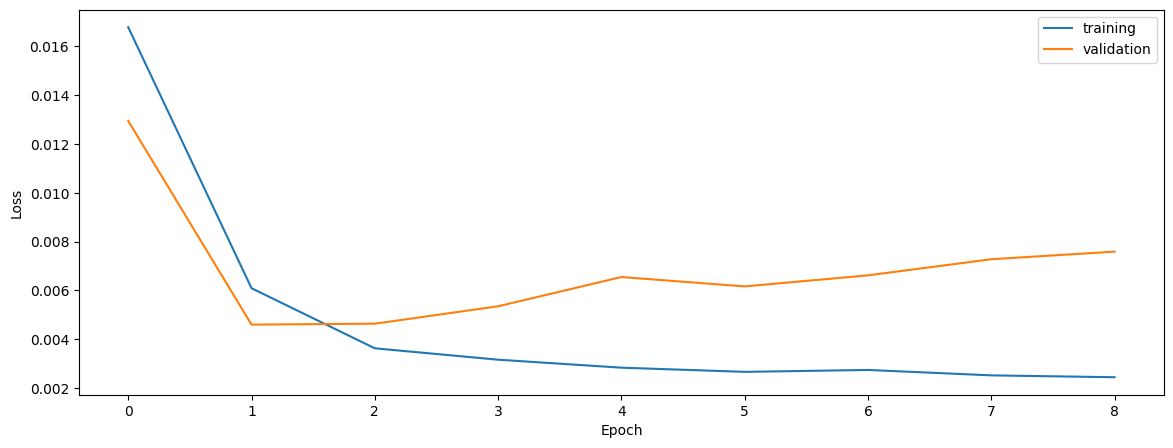

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.6126073009178127
0.6181728736209676
0.6299688502487331


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

native
0.6132740459053218
0.6179799582434619
0.632156061580729


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6253963501365788
0.6401718035268954
0.661180522987439


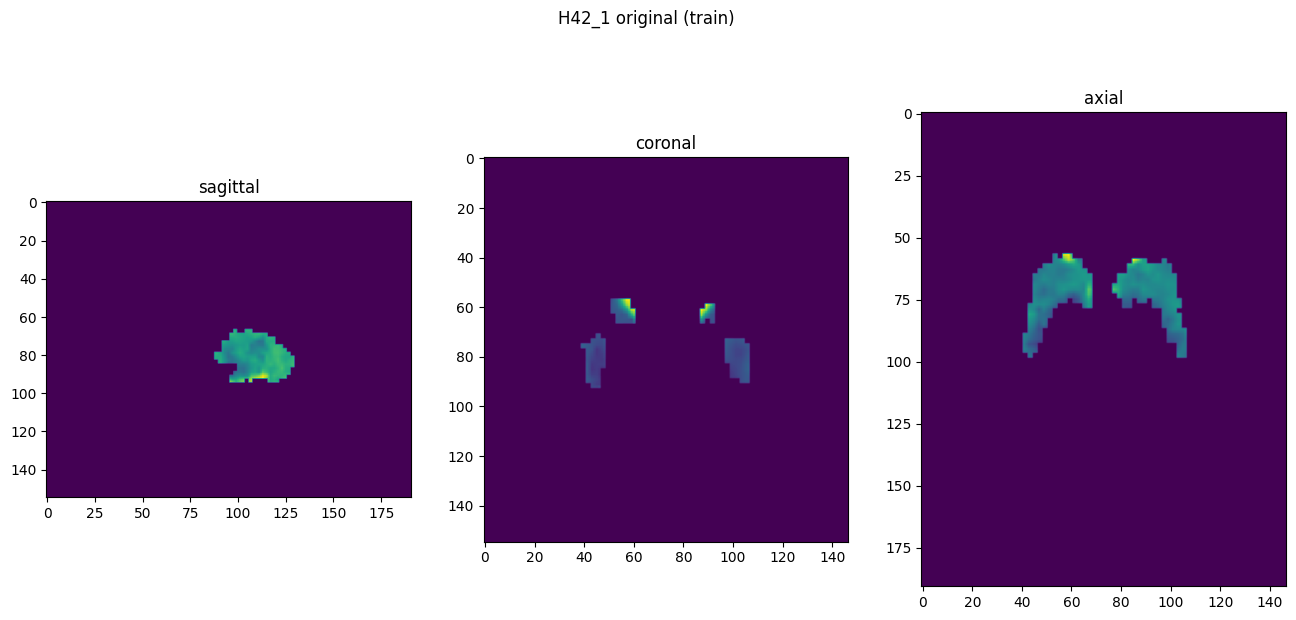

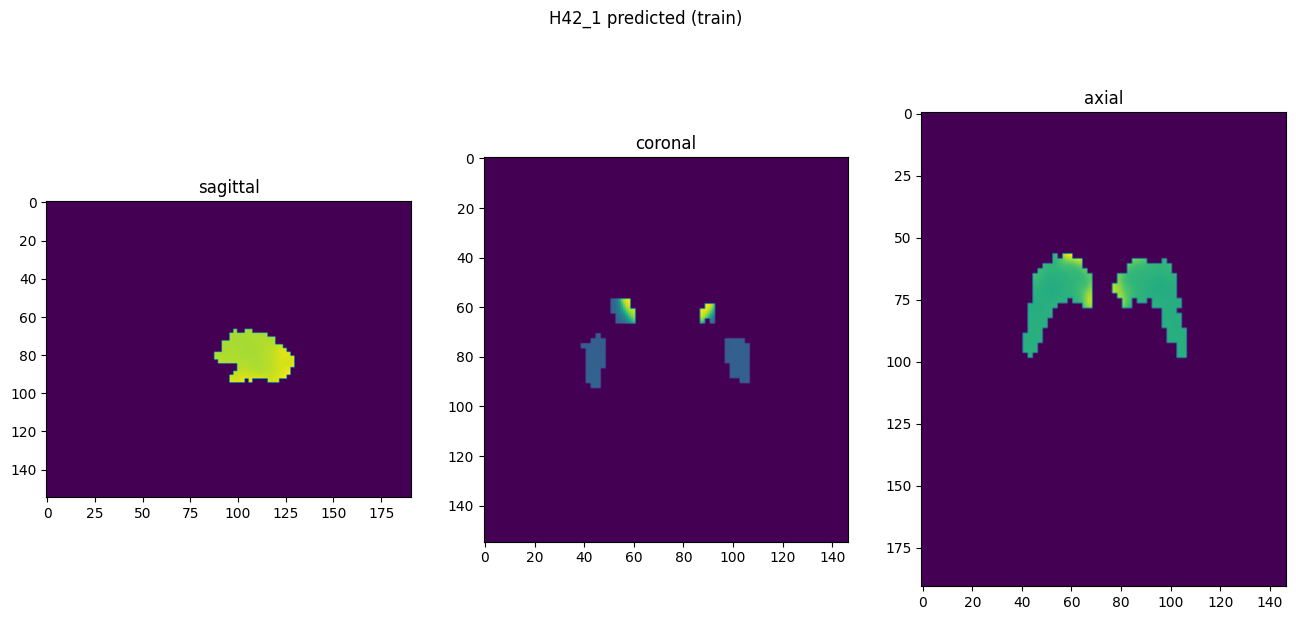

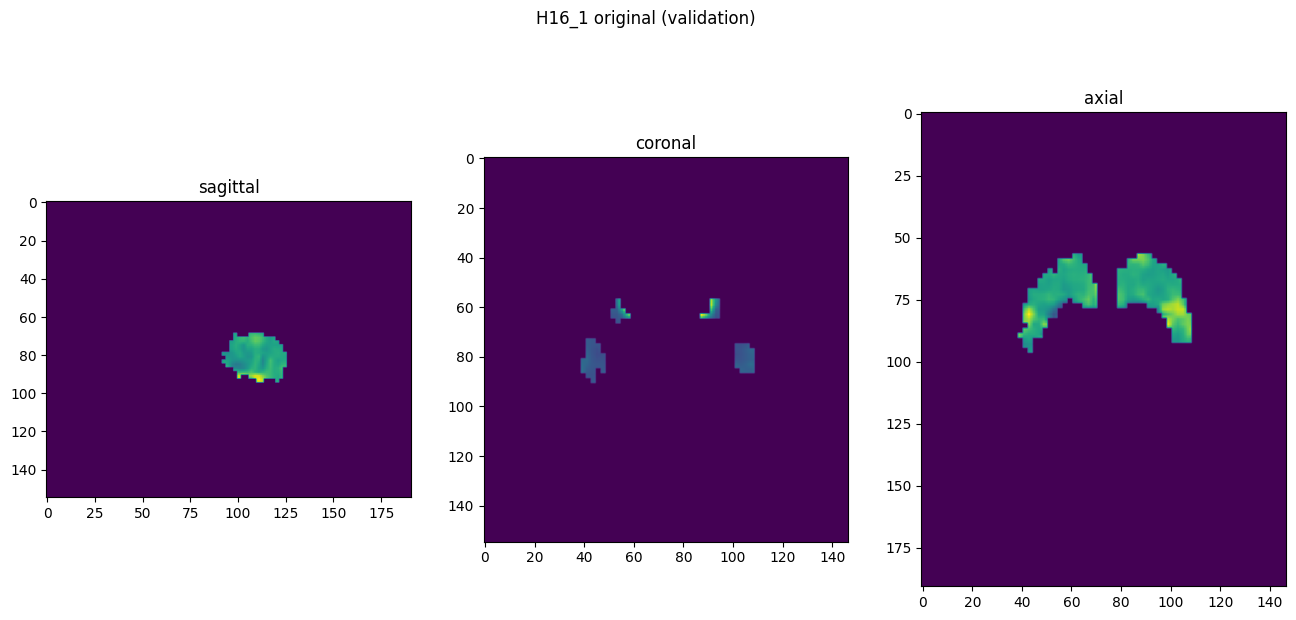

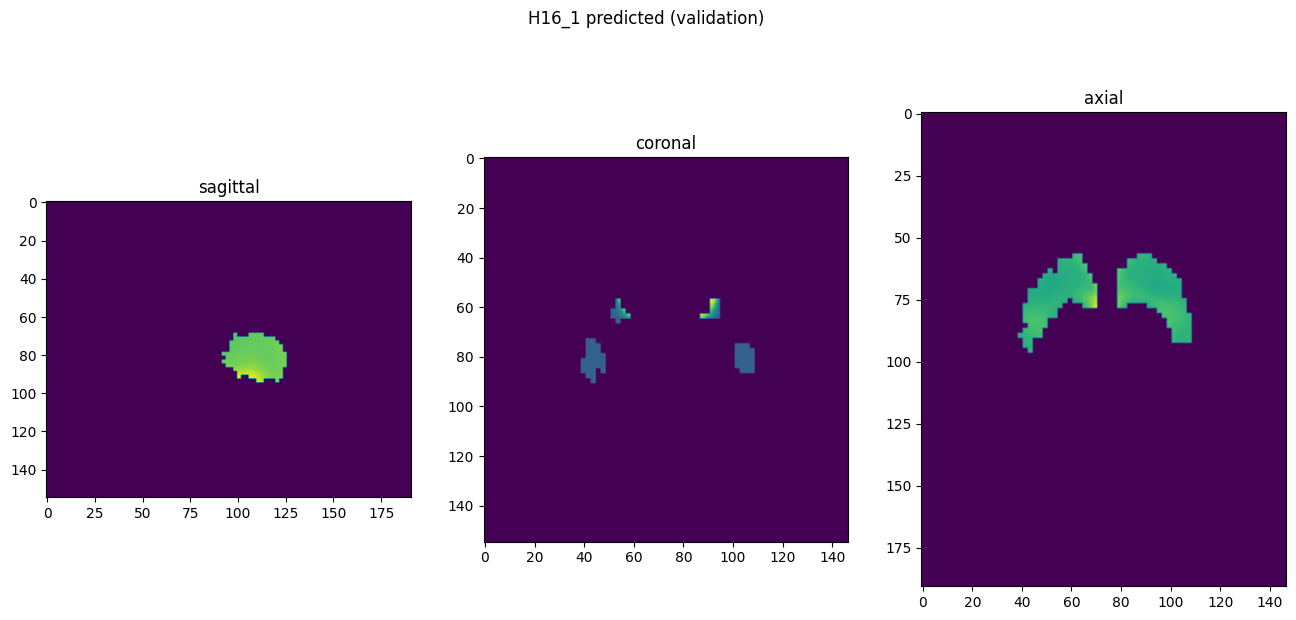

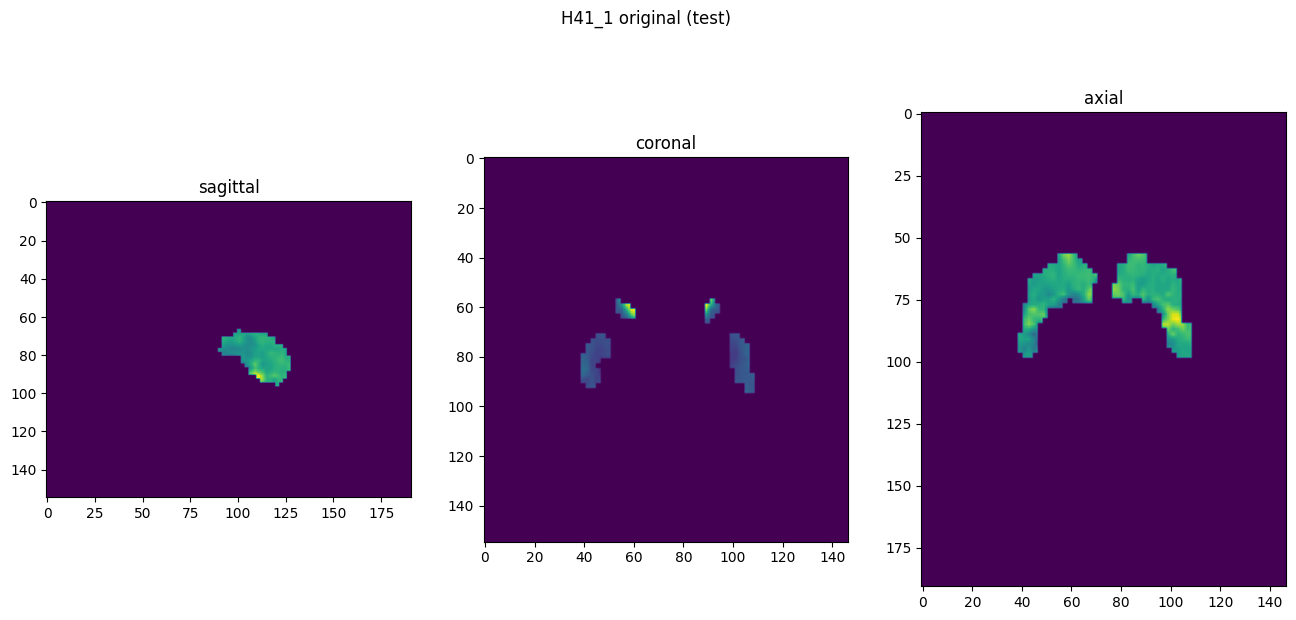

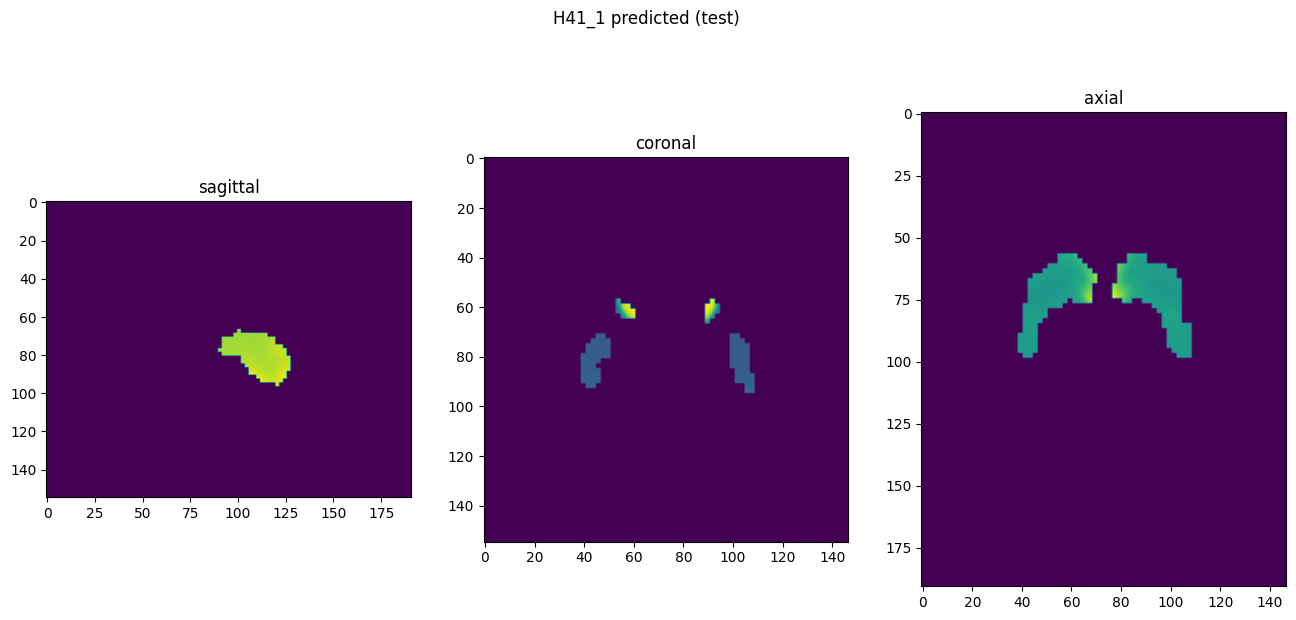

In [10]:
showResults(model, gen, threshold=None, background=False)